# Chapter6. 알고리즘 체인과 파이프라인

In [2]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn

%matplotlib inline

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [4]:
# 경고 메세지 제거
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'This pattern has match groups')
warnings.filterwarnings('ignore', 'The iterable function was deprecated in Matplotlib')

----------------------------------

In [13]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)

print('테스트 점수 : {:.3f}'.format(svm.score(X_test_scaled, y_test)))

테스트 점수 : 0.972


# 6.1 데이터 전처리와 매개변수 선택

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C' :[0.001, 0.01, 0.1, 1, 10, 100],
             'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print('최상의 교차 검증 정확도 : {:.2f}'.format(grid.best_score_))
print('테스트 점수 : {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('최적의 매개변수 : ', grid.best_params_)

최상의 교차 검증 정확도 : 0.98
테스트 점수 : 0.97
최적의 매개변수 :  {'C': 1, 'gamma': 1}


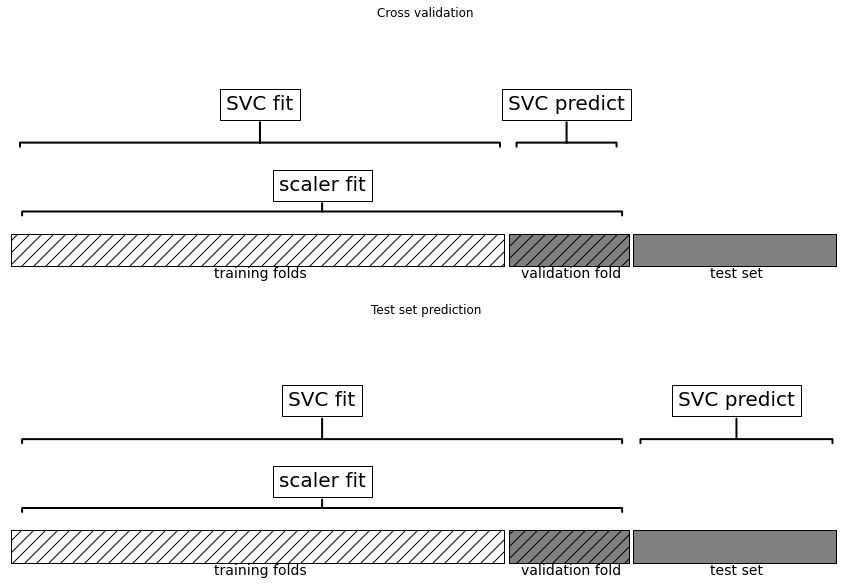

In [19]:
mglearn.plots.plot_improper_processing()

# 6.2 파이프라인 구축하기

In [21]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

In [22]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [23]:
print('테스트 점수 : {:.2f}'.format(pipe.score(X_test, y_test)))

테스트 점수 : 0.97


# 6.3 그리드 서치에 파이프라인 적용하기

In [26]:
param_grid = {'svm__C' : [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}

In [30]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('최상의 교차 검증 정확도 : {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수 : {:.2f}'.format(grid.score(X_test, y_test)))
print('최적의 매개변수 : ',grid.best_params_)

최상의 교차 검증 정확도 : 0.98
테스트 세트 점수 : 0.97
최적의 매개변수 :  {'svm__C': 1, 'svm__gamma': 1}


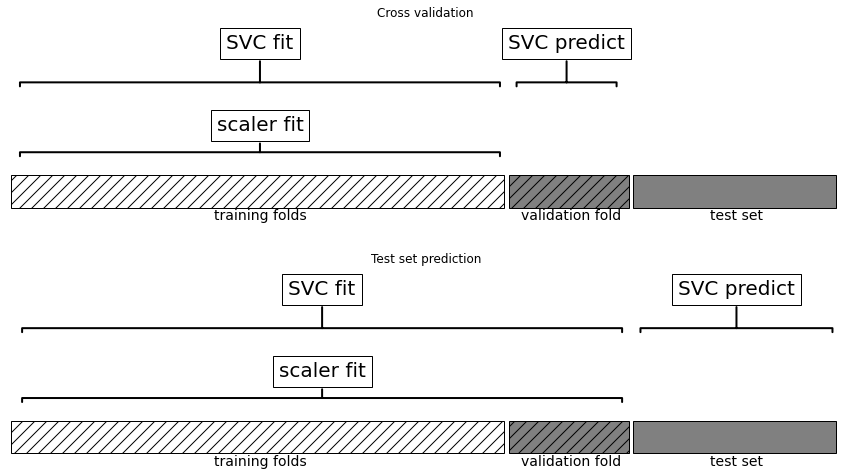

In [31]:
mglearn.plots.plot_proper_processing()

### 정보 누설에 대한 예시

In [34]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [40]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print('X_selected.shape : ', X_selected.shape)

X_selected.shape :  (100, 500)


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print('교차 검증 점수(리지) : {:.2f}'.format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수(리지) : 0.91


In [46]:
pipe = Pipeline([('select', SelectPercentile(score_func = f_regression, percentile=5)),
                ('ridge', Ridge())])
print('교차 검증 점수(파이프라인) : {:.2f}'.format(np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 점수(파이프라인) : -0.25


# 6.4.1 make_pipeline을 사용한 파이프라인 생성

In [54]:
from sklearn.pipeline import make_pipeline

# 표준적인 방법
pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C=100))])

# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [55]:
# 파이프 라인의 각 단계 확인
print('파이프라인 단계 : \n', pipe_short.steps)
print('파이프라인 단계 : \n', pipe_long.steps)

파이프라인 단계 : 
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]
파이프라인 단계 : 
 [('scaler', MinMaxScaler()), ('svm', SVC(C=100))]


In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print('파이프라인의 단계 : ', pipe.steps)

파이프라인의 단계 :  [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


# 6.4.2 단계 속성에 접근하기

파이프라인의 단계 중 하나의 속성을 확인하고 싶을때

In [65]:
pipe.fit(cancer.data)

components = pipe.named_steps['pca'].components_
print('components.shape', components.shape)

components.shape (2, 30)


In [66]:
pipe.steps

[('standardscaler-1', StandardScaler()),
 ('pca', PCA(n_components=2)),
 ('standardscaler-2', StandardScaler())]

# 6.4.2 그리드 서치 안의 파이프라인 속성에 접근하기

In [67]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [68]:
param_grid = {'logisticregression__C' : [0.01, 0.1, 1, 10, 100]}

In [69]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [70]:
print('최상의 모델 : ', grid.best_estimator_)

최상의 모델 :  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


In [72]:
print('로지스틱 회귀 단계 : \n', grid.best_estimator_.named_steps['logisticregression'])

로지스틱 회귀 단계 : 
 LogisticRegression(C=1)


In [74]:
print('로지스틱 회귀 계수 : \n', grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 계수 : 
 [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


# 6.5 전처리 모델의 매개변수를 위한 그리드 서치

In [91]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [92]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [94]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

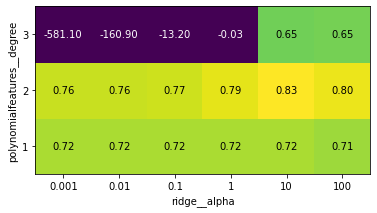

In [99]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)
plt.show()

# R^2 결정 계수를 기준으로 나타냄

In [101]:
print('최적의 매개변수 : ', grid.best_params_)

최적의 매개변수 :  {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [102]:
print('테스트 세트 점수 : {:.2f}'.format(grid.score(X_test, y_test)))

테스트 세트 점수 : 0.77


In [108]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


# 6.6 모델 선택을 위한 그리드 서치

In [109]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [114]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'classifier':[SVC()],
              'preprocessing':[StandardScaler()],
              'classifier__gamma' : [0.001, 0.01, 0.1, 1, 10, 100],
              'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100]},
              {'classifier':[RandomForestClassifier(n_estimators=100)],
              'preprocessing':[None], 'classifier__max_features':[1,2,3]}]

In [119]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('최적의 매개변수 : \n{}\n'.format(grid.best_params_))
print('최상의 교차 검증 점수 : {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수 : {:.2f}'.format(grid.score(X_test, y_test)))

최적의 매개변수 : 
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수 : 0.99
테스트 세트 점수 : 0.98


# 6.6.1 중복 계산 피하기

In [120]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())], memory='cache_folder')